# Finding optimal spectrogram parameters
To reproduce the analysis, first you will need to run all of the .sh scripts in the analyses/input_representation/ folder (those are made for SBATCH, for running in parallel). Then, run all the cells in this notebook!

### STFT nperseg and poverlap and window type

In [6]:
import torch
import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset
import numpy as np
import json, os

def load_results(dirname, subject_trials):
    results_array = np.zeros((len(subject_trials), len(neuroprobe_config.NEUROPROBE_TASKS)))
    for st_i, (subject_id, trial_id) in enumerate(subject_trials):
        for t_i, task_name in enumerate(neuroprobe_config.NEUROPROBE_TASKS):
            results_path = os.path.join(dirname, f"population_btbank{subject_id}_{trial_id}_{task_name}.json")
            with open(results_path, "r") as f:
                results = json.load(f)
                results = results["evaluation_results"][f"btbank{subject_id}_{trial_id}"]["population"]["one_second_after_onset"]
                results = np.mean([fold["test_roc_auc"] for fold in results["folds"]])
            results_array[st_i, t_i] = results
    return results_array

# noverlap: 0%, 25%, 50%, 75%, 87.5%, 93.75%
# nperseg: 400, 512, 256, 128
poverlap_options = [0.0, 0.25, 0.5, 0.75, 0.875]#, 0.9375, 0.96875]
nperseg_options = [128, 256, 400, 512, 768, 1024]

NEUROPROBE_LITE_RESULTS_HANN = np.zeros((len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(poverlap_options), len(nperseg_options)))
NEUROPROBE_LITE_RESULTS_BOXCAR = np.zeros((len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(poverlap_options), len(nperseg_options)))

for poverlap_i, poverlap in enumerate(poverlap_options):
    for nperseg_i, nperseg in enumerate(nperseg_options):
        NEUROPROBE_LITE_RESULTS_HANN[:, :, poverlap_i, nperseg_i] = load_results(f"data/analyses/input_representation/eval_results_lite_SS_DM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}_maxfreq150", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)
        # NEUROPROBE_LITE_RESULTS_BOXCAR[:, :, poverlap_i, nperseg_i] = load_results(f"data/analyses/input_representation/eval_results_lite_SS_SM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}_boxcar", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)

Hann Window

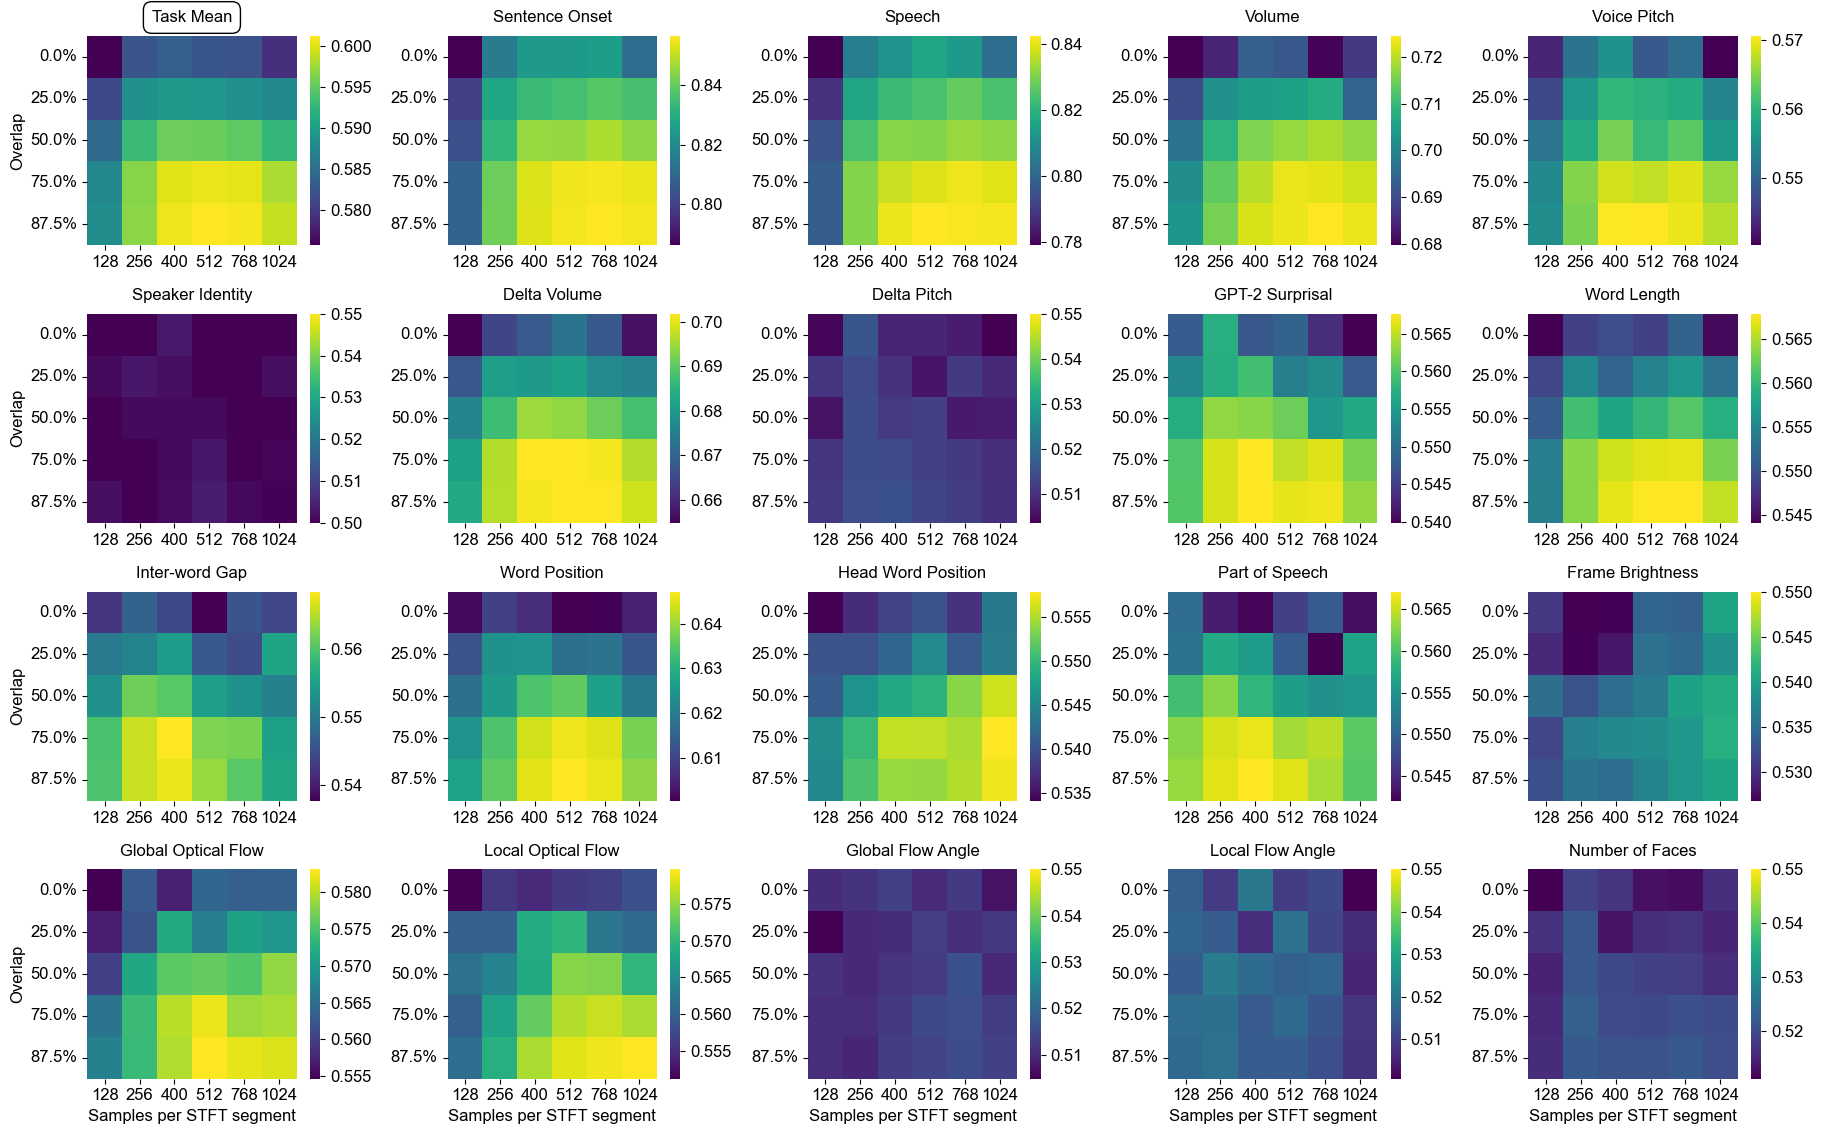

In [7]:
RESULTS_mean_st = NEUROPROBE_LITE_RESULTS_HANN.mean(axis=0) # shape: (n_tasks, n_poverlaps, n_npersegs)


import seaborn as sns
import math
import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})


# Create figure with 4x5 grid - reduced size
n_cols = 5
n_rows = math.ceil((len(neuroprobe_config.NEUROPROBE_TASKS)+1)/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.3*8/5*n_cols, 2.3*5/4*n_rows))

# Flatten axs for easier iteration
axs_flat = axs.flatten()

# Plot overall performance heatmap in first axis
first_ax = axs_flat[0]
mean_overall = RESULTS_mean_st.mean(axis=0)  # Average across tasks
hann_vmin_max = {
    'overall': (max(0.5, mean_overall.min()), max(0.55, mean_overall.max()))
}
sns.heatmap(mean_overall, 
            ax=first_ax,
            xticklabels=nperseg_options,
            yticklabels=[f"{p*100:.1f}%" for p in poverlap_options],
            cmap='viridis',
            vmin=hann_vmin_max['overall'][0],
            vmax=hann_vmin_max['overall'][1],
            cbar=True)
first_ax.set_title('Task Mean', fontsize=12, pad=10, fontweight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# first_ax.set_xlabel('nperseg')
first_ax.set_ylabel('Overlap')

# Plot counter - start from 1 for remaining plots
plot_idx = 1

for task in neuroprobe_config.NEUROPROBE_TASKS_MAPPING:
    ax = axs_flat[plot_idx]
    t_i = neuroprobe_config.NEUROPROBE_TASKS.index(task)

    hann_vmin_max[task] = (max(0.5, RESULTS_mean_st[t_i].min()), max(0.55, RESULTS_mean_st[t_i].max()))
    
    # Plot heatmap for each task
    sns.heatmap(RESULTS_mean_st[t_i],
                ax=ax,
                xticklabels=nperseg_options,
                yticklabels=[f"{p*100:.1f}%" for p in poverlap_options],
                cmap='viridis',
                vmin=hann_vmin_max[task][0],
                vmax=hann_vmin_max[task][1],
                cbar=True)
    
    ax.set_title(neuroprobe_config.NEUROPROBE_TASKS_MAPPING[task], fontsize=12, pad=10, fontweight='bold')
    
    if plot_idx % 5 == 0:  # Right-most plots
        ax.set_ylabel('Overlap')
    else:
        ax.set_ylabel('')
        
    if plot_idx >= len(neuroprobe_config.NEUROPROBE_TASKS_MAPPING) - 4:  # Bottom plots
        ax.set_xlabel('Samples per STFT segment')
    else:
        ax.set_xlabel('')
    
    plot_idx += 1

# Remove empty subplots if any
for idx in range(plot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.show()


Boxcar window. Evidently, much worse accuracy than the Hann window!

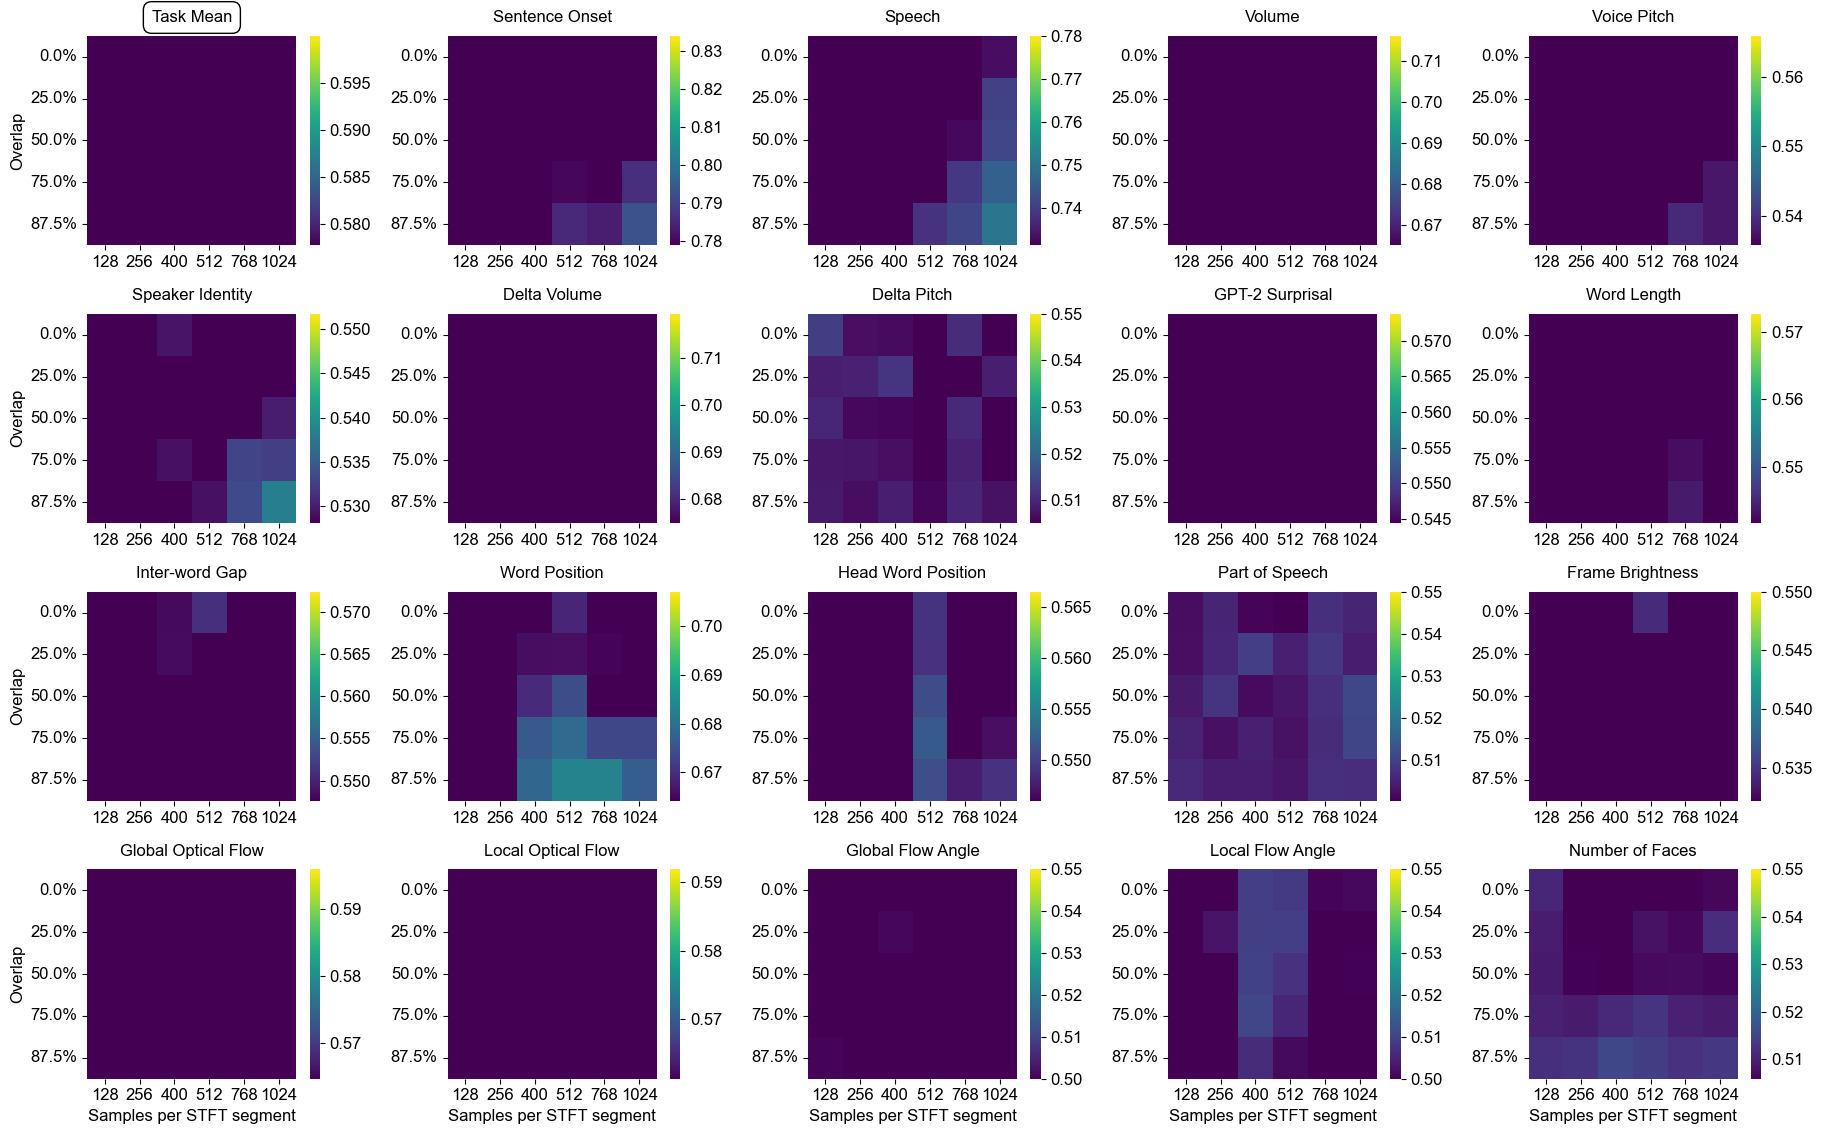

In [9]:
RESULTS_mean_st = NEUROPROBE_LITE_RESULTS_BOXCAR.mean(axis=0) # shape: (n_tasks, n_poverlaps, n_npersegs)


import seaborn as sns
import math
import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})


# Create figure with 4x5 grid - reduced size
n_cols = 5
n_rows = math.ceil((len(neuroprobe_config.NEUROPROBE_TASKS)+1)/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.3*8/5*n_cols, 2.3*5/4*n_rows))

# Flatten axs for easier iteration
axs_flat = axs.flatten()

# Plot overall performance heatmap in first axis
first_ax = axs_flat[0]
mean_overall = RESULTS_mean_st.mean(axis=0)  # Average across tasks
sns.heatmap(mean_overall, 
            ax=first_ax,
            xticklabels=nperseg_options,
            yticklabels=[f"{p*100:.1f}%" for p in poverlap_options],
            cmap='viridis',
            vmin=hann_vmin_max['overall'][0],
            vmax=hann_vmin_max['overall'][1],
            cbar=True)
first_ax.set_title('Task Mean', fontsize=12, pad=10, fontweight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# first_ax.set_xlabel('nperseg')
first_ax.set_ylabel('Overlap')

# Plot counter - start from 1 for remaining plots
plot_idx = 1

for task in neuroprobe_config.NEUROPROBE_TASKS_MAPPING:
    ax = axs_flat[plot_idx]
    t_i = neuroprobe_config.NEUROPROBE_TASKS.index(task)
    
    # Plot heatmap for each task
    sns.heatmap(RESULTS_mean_st[t_i],
                ax=ax,
                xticklabels=nperseg_options,
                yticklabels=[f"{p*100:.1f}%" for p in poverlap_options],
                cmap='viridis',
                vmin=hann_vmin_max[task][0],
                vmax=hann_vmin_max[task][1],
                cbar=True)
    
    ax.set_title(neuroprobe_config.NEUROPROBE_TASKS_MAPPING[task], fontsize=12, pad=10, fontweight='bold')
    
    if plot_idx % 5 == 0:  # Right-most plots
        ax.set_ylabel('Overlap')
    else:
        ax.set_ylabel('')
        
    if plot_idx >= len(neuroprobe_config.NEUROPROBE_TASKS_MAPPING) - 4:  # Bottom plots
        ax.set_xlabel('Samples per STFT segment')
    else:
        ax.set_xlabel('')
    
    plot_idx += 1

# Remove empty subplots if any
for idx in range(plot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.show()


### STFT max frequency

p_overlap=87.5%

In [1]:
import torch
import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset
import numpy as np
import json, os

def load_results(dirname, subject_trials):
    results_array = np.zeros((len(subject_trials), len(neuroprobe_config.NEUROPROBE_TASKS)))
    for st_i, (subject_id, trial_id) in enumerate(subject_trials):
        for t_i, task_name in enumerate(neuroprobe_config.NEUROPROBE_TASKS):
            results_path = os.path.join(dirname, f"population_btbank{subject_id}_{trial_id}_{task_name}.json")
            with open(results_path, "r") as f:
                results = json.load(f)
                results = results["evaluation_results"][f"btbank{subject_id}_{trial_id}"]["population"]["one_second_after_onset"]
                results = np.mean([fold["test_roc_auc"] for fold in results["folds"]])
            results_array[st_i, t_i] = results
    return results_array

# noverlap: 0%, 25%, 50%, 75%, 87.5%, 93.75%
# nperseg: 400, 512, 256, 128
poverlap=0.875
maxfreq_options = [50, 100, 150, 200, 250, 300, 350, 400]
nperseg_options = [128, 256, 400, 512, 768, 1024]

NEUROPROBE_LITE_RESULTS_HANN = np.zeros((len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(maxfreq_options), len(nperseg_options)))

for maxfreq_i, maxfreq in enumerate(maxfreq_options):
    for nperseg_i, nperseg in enumerate(nperseg_options):
        maxfreq_suffix = f"_maxfreq{maxfreq}" if maxfreq != 200 else ""
        NEUROPROBE_LITE_RESULTS_HANN[:, :, maxfreq_i, nperseg_i] = load_results(f"data/analyses/input_representation/eval_results_lite_SS_SM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}{maxfreq_suffix}", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)

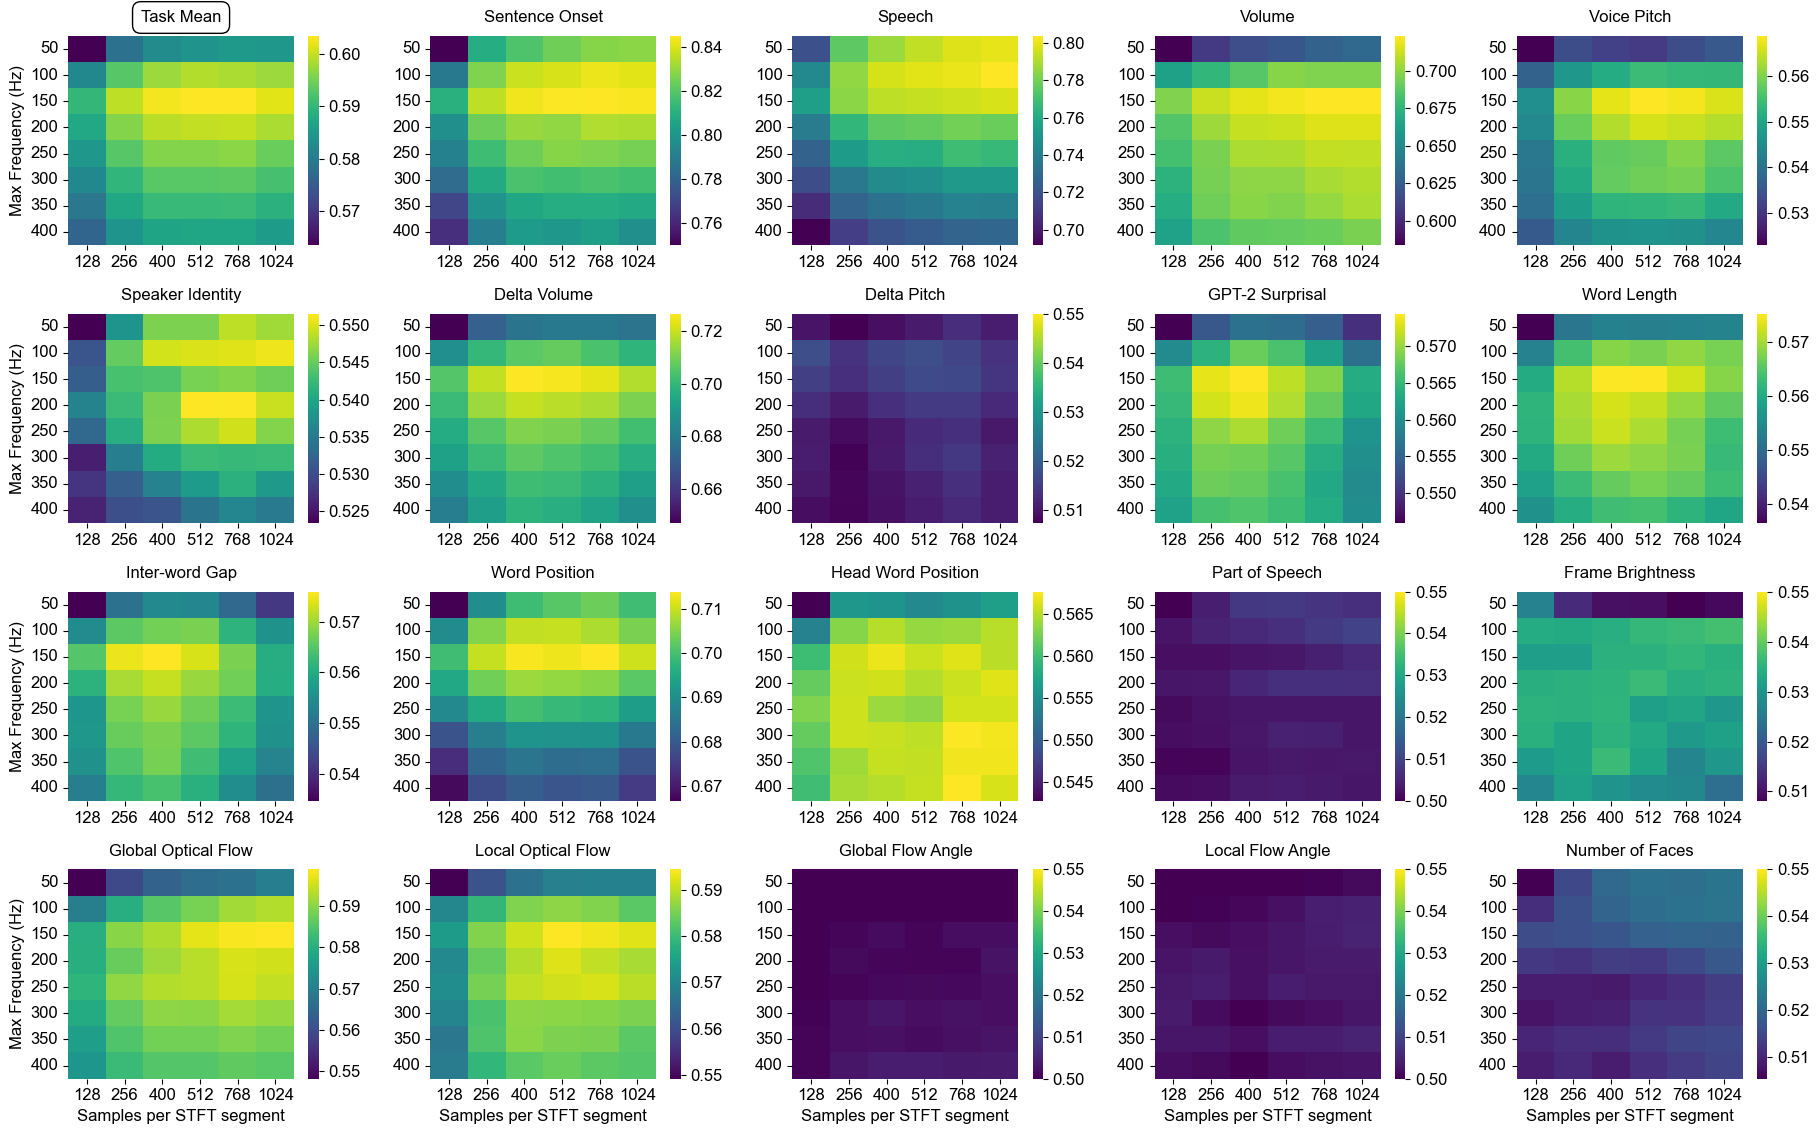

In [2]:
RESULTS_mean_st = NEUROPROBE_LITE_RESULTS_HANN.mean(axis=0) # shape: (n_tasks, n_maxfreqs, n_npersegs)


import seaborn as sns
import math
import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})


# Create figure with 4x5 grid - reduced size
n_cols = 5
n_rows = math.ceil((len(neuroprobe_config.NEUROPROBE_TASKS)+1)/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.3*8/5*n_cols, 2.3*5/4*n_rows))

# Flatten axs for easier iteration
axs_flat = axs.flatten()

# Plot overall performance heatmap in first axis
first_ax = axs_flat[0]
mean_overall = RESULTS_mean_st.mean(axis=0)  # Average across tasks
hann_vmin_max = {
    'overall': (max(0.5, mean_overall.min()), max(0.55, mean_overall.max()))
}
sns.heatmap(mean_overall, 
            ax=first_ax,
            xticklabels=nperseg_options,
            yticklabels=maxfreq_options,
            cmap='viridis',
            vmin=hann_vmin_max['overall'][0],
            vmax=hann_vmin_max['overall'][1],
            cbar=True)
first_ax.set_title('Task Mean', fontsize=12, pad=10, fontweight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# first_ax.set_xlabel('nperseg')
first_ax.set_ylabel('Max Frequency (Hz)')

# Plot counter - start from 1 for remaining plots
plot_idx = 1

for task in neuroprobe_config.NEUROPROBE_TASKS_MAPPING:
    ax = axs_flat[plot_idx]
    t_i = neuroprobe_config.NEUROPROBE_TASKS.index(task)

    hann_vmin_max[task] = (max(0.5, RESULTS_mean_st[t_i].min()), max(0.55, RESULTS_mean_st[t_i].max()))
    
    # Plot heatmap for each task
    sns.heatmap(RESULTS_mean_st[t_i],
                ax=ax,
                xticklabels=nperseg_options,
                yticklabels=maxfreq_options,
                cmap='viridis',
                vmin=hann_vmin_max[task][0],
                vmax=hann_vmin_max[task][1],
                cbar=True)
    
    ax.set_title(neuroprobe_config.NEUROPROBE_TASKS_MAPPING[task], fontsize=12, pad=10, fontweight='bold')
    
    if plot_idx % 5 == 0:  # Right-most plots
        ax.set_ylabel('Max Frequency (Hz)')
    else:
        ax.set_ylabel('')
        
    if plot_idx >= len(neuroprobe_config.NEUROPROBE_TASKS_MAPPING) - 4:  # Bottom plots
        ax.set_xlabel('Samples per STFT segment')
    else:
        ax.set_xlabel('')
    
    plot_idx += 1

# Remove empty subplots if any
for idx in range(plot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.show()


### STFT max frequency

Min / Max Frequency Analysis

In [9]:
import torch
import numpy as np
import json, os

os.environ["ROOT_DIR_BRAINTREEBANK"] = "/om2/user/zaho/braintreebank/braintreebank/"


import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset

def load_results(dirname, subject_trials):
    results_array = np.zeros((len(subject_trials), len(neuroprobe_config.NEUROPROBE_TASKS)))
    for st_i, (subject_id, trial_id) in enumerate(subject_trials):
        for t_i, task_name in enumerate(neuroprobe_config.NEUROPROBE_TASKS):
            results_path = os.path.join(dirname, f"population_btbank{subject_id}_{trial_id}_{task_name}.json")
            if not os.path.exists(results_path):
                results_array[st_i, t_i] = np.nan
                print("Warning: results path does not exist:", results_path)
                continue
            with open(results_path, "r") as f:
                results = json.load(f)
                results = results["evaluation_results"][f"btbank{subject_id}_{trial_id}"]["population"]["one_second_after_onset"]
                results = np.mean([fold["test_roc_auc"] for fold in results["folds"]])
            results_array[st_i, t_i] = results
    return results_array
# Min/Max frequency analysis based on run_optimal_minmax_frequency.sh
poverlap=0.75
nperseg=512
minfreq_options = [0, 10, 20, 30, 40, 50]#, 60, 70]
maxfreq_options = [100, 150, 200, 250, 300]

NEUROPROBE_LITE_RESULTS_MINMAX = np.zeros((len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS),
                                    len(neuroprobe_config.NEUROPROBE_TASKS),
                                    len(minfreq_options), len(maxfreq_options)))
for minfreq_i, minfreq in enumerate(minfreq_options):
    for maxfreq_i, maxfreq in enumerate(maxfreq_options):
        minfreq_suffix = f"_minfreq{minfreq}" if minfreq != 0 else ""
        maxfreq_suffix = f"_maxfreq{maxfreq}"
        NEUROPROBE_LITE_RESULTS_MINMAX[:, :, minfreq_i, maxfreq_i] = load_results(f"data/analyses/input_representation/eval_results_lite_SS_DM/linear_stft_abs_nperseg{nperseg}_poverlap{poverlap}{maxfreq_suffix}{minfreq_suffix}", neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS)

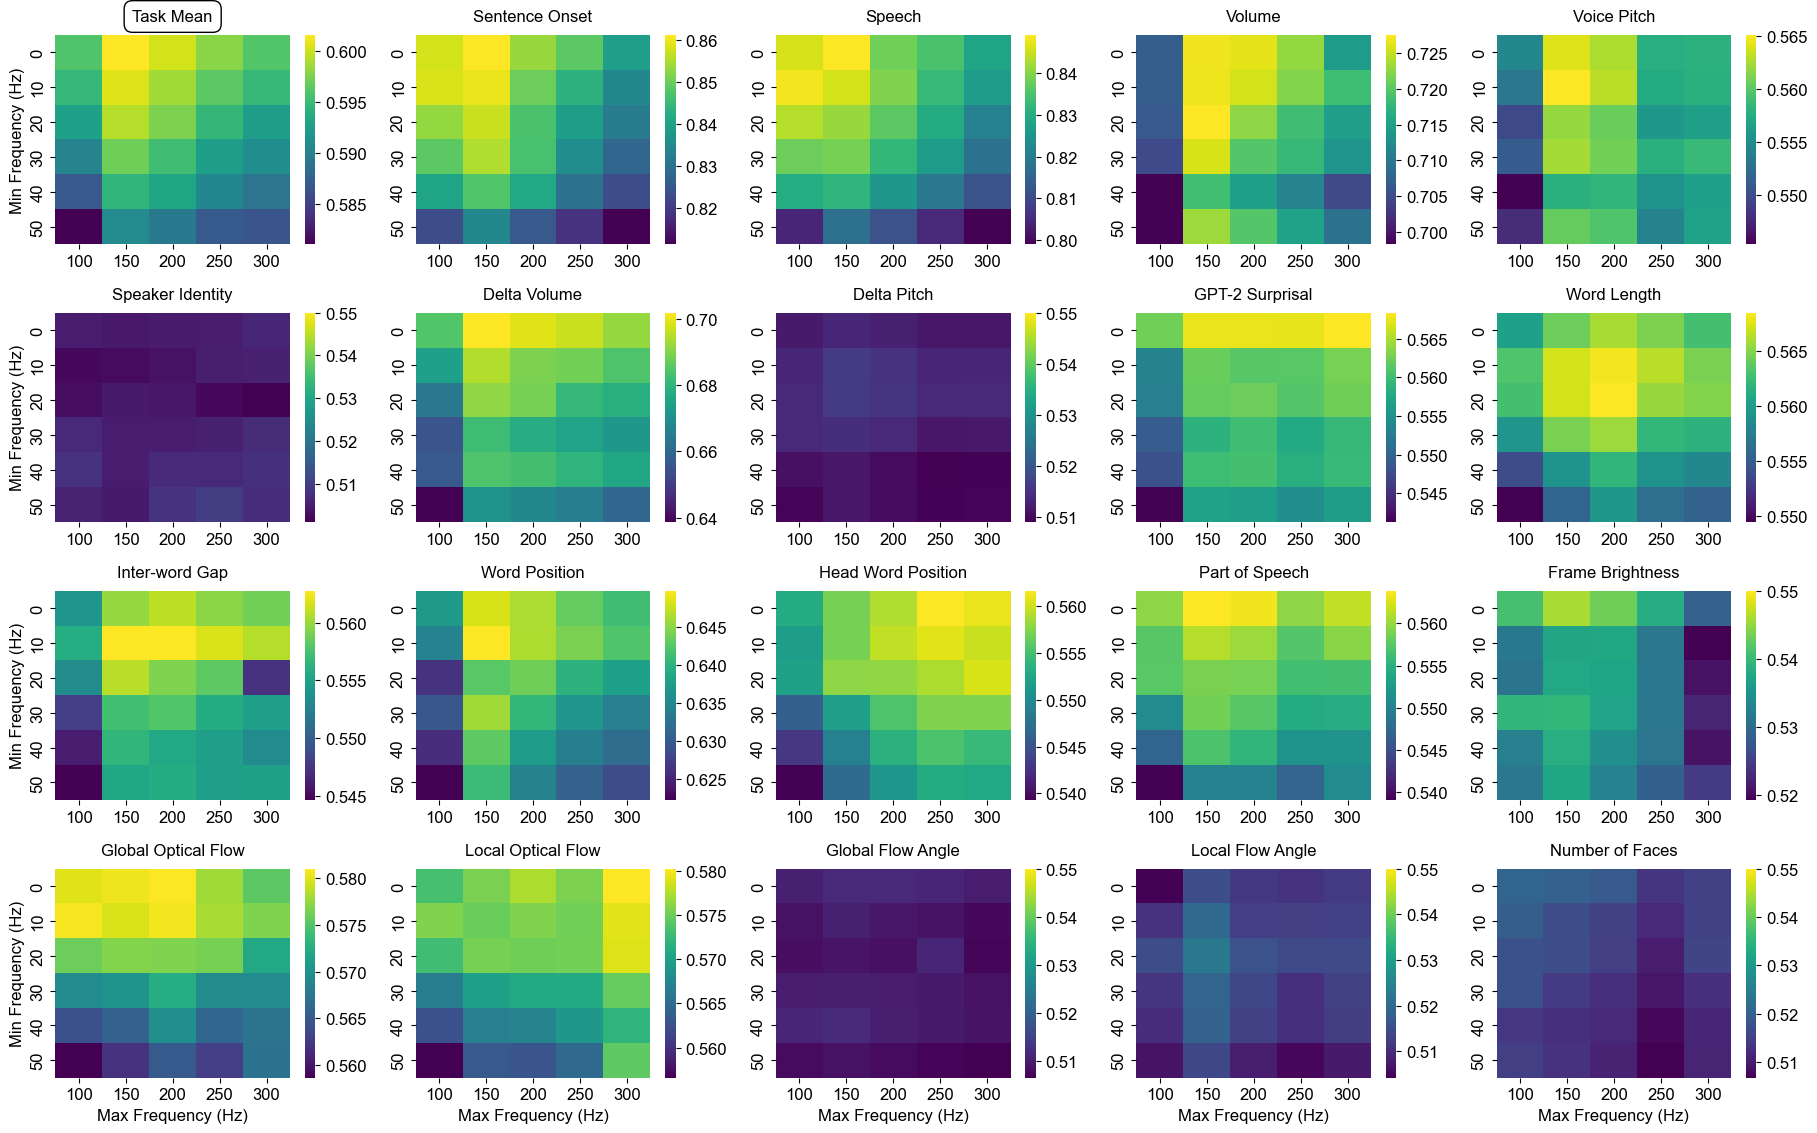

In [10]:
RESULTS_mean_st = np.nanmean(NEUROPROBE_LITE_RESULTS_MINMAX, axis=0) # shape: (n_tasks, n_minfreqs, n_maxfreqs)


import seaborn as sns
import math
import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})


# Create figure with 4x5 grid - reduced size
n_cols = 5
n_rows = math.ceil((len(neuroprobe_config.NEUROPROBE_TASKS)+1)/n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(2.3*8/5*n_cols, 2.3*5/4*n_rows))

# Flatten axs for easier iteration
axs_flat = axs.flatten()

# Plot overall performance heatmap in first axis
first_ax = axs_flat[0]
mean_overall = np.nanmean(RESULTS_mean_st, axis=0)  # Average across tasks
minmax_vmin_max = {
    'overall': (max(0.5, np.nanmin(mean_overall)), max(0.55, np.nanmax(mean_overall)))
}
sns.heatmap(mean_overall, 
            ax=first_ax,
            xticklabels=maxfreq_options,
            yticklabels=minfreq_options,
            cmap='viridis',
            vmin=minmax_vmin_max['overall'][0],
            vmax=minmax_vmin_max['overall'][1],
            cbar=True)
first_ax.set_title('Task Mean', fontsize=12, pad=10, fontweight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# first_ax.set_xlabel('Max Frequency (Hz)')
first_ax.set_ylabel('Min Frequency (Hz)')

# Plot counter - start from 1 for remaining plots
plot_idx = 1

for task in neuroprobe_config.NEUROPROBE_TASKS_MAPPING:
    ax = axs_flat[plot_idx]
    t_i = neuroprobe_config.NEUROPROBE_TASKS.index(task)

    minmax_vmin_max[task] = (max(0.5, np.nanmin(RESULTS_mean_st[t_i])), max(0.55, np.nanmax(RESULTS_mean_st[t_i])))
    
    # Plot heatmap for each task
    sns.heatmap(RESULTS_mean_st[t_i],
                ax=ax,
                xticklabels=maxfreq_options,
                yticklabels=minfreq_options,
                cmap='viridis',
                vmin=minmax_vmin_max[task][0],
                vmax=minmax_vmin_max[task][1],
                cbar=True)
    
    ax.set_title(neuroprobe_config.NEUROPROBE_TASKS_MAPPING[task], fontsize=12, pad=10, fontweight='bold')
    
    if plot_idx % 5 == 0:  # Right-most plots
        ax.set_ylabel('Min Frequency (Hz)')
    else:
        ax.set_ylabel('')
        
    if plot_idx >= len(neuroprobe_config.NEUROPROBE_TASKS_MAPPING) - 4:  # Bottom plots
        ax.set_xlabel('Max Frequency (Hz)')
    else:
        ax.set_xlabel('')
    
    plot_idx += 1

# Remove empty subplots if any
for idx in range(plot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.show()
